**Forecasting Copper Prices**
=============================

In [612]:
import numpy as np
import pandas as pd
import os
import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import OleFileIO_PL
import re
import warnings

## **Importing Packages**

In [613]:
sns.set_style('darkgrid')
# to ignore warnings
warnings.filterwarnings("ignore")

## **Loading Datasets**

### Copper Prices

In [614]:
# Path to the directory containing CSV files
directory_path = 'Datasets/copper_prices'

# List to store DataFrames
all_dfs = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        # Read each CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Append the DataFrame to the list
        all_dfs.append(df)

# Merge all DataFrames into one
copper_history = pd.concat(all_dfs, ignore_index=True)

# Display the merged DataFrame
copper_history
  

,Date,Price,Open,High,Low,Vol.,Change %
0,10/28/2019,2.6830,2.6850,2.6890,2.6735,49.12K,0.28%
1,10/25/2019,2.6755,2.6665,2.6905,2.6590,57.34K,0.28%
2,10/24/2019,2.6680,2.6690,2.6795,2.6590,61.06K,-0.13%
3,10/23/2019,2.6715,2.6355,2.6745,2.6145,75.68K,1.46%
4,10/22/2019,2.6330,2.6450,2.6505,2.6295,46.14K,-0.51%
...,...,...,...,...,...,...,...
8969,11/03/2023,3.6815,3.6880,3.7050,3.6530,81.35K,0.25%
8970,11/02/2023,3.6725,3.6605,3.6925,3.6565,71.37K,0.64%
8971,11/01/2023,3.6490,3.6530,3.6890,3.6335,83.30K,0.00%
8972,10/31/2023,3.6490,3.6550,3.6745,3.6315,72.26K,-0.26%


In [615]:
# Removing Unnecessary Columns
copper_history = copper_history.drop(columns=['Vol.', 'Change %', 'Open', 'High', 'Low'])
copper_history

,Date,Price
0,10/28/2019,2.6830
1,10/25/2019,2.6755
2,10/24/2019,2.6680
3,10/23/2019,2.6715
4,10/22/2019,2.6330
...,...,...
8969,11/03/2023,3.6815
8970,11/02/2023,3.6725
8971,11/01/2023,3.6490
8972,10/31/2023,3.6490


In [616]:


# Convert 'Date' column to datetime
copper_history['Date'] = pd.to_datetime(copper_history['Date'], errors='coerce')

# Convert 'Date' column to YYYY-MM-DD format
copper_history['Date'] = copper_history['Date'].dt.strftime('%Y-%m-%d')

copper_history['Date'] = pd.to_datetime(copper_history['Date'])
copper_history

,Date,Price
0,2019-10-28,2.6830
1,2019-10-25,2.6755
2,2019-10-24,2.6680
3,2019-10-23,2.6715
4,2019-10-22,2.6330
...,...,...
8969,2023-11-03,3.6815
8970,2023-11-02,3.6725
8971,2023-11-01,3.6490
8972,2023-10-31,3.6490


In [617]:
copper_history.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

## Check for Missing Values

In [618]:
rows_with_missing = copper_history[copper_history.isna().any(axis=1)]
rows_with_missing

,Date,Price


In [689]:
copper_history

,Date,Price,Day,Month,Year
2869,2000-01-04,0.8480,4,1,2000
2870,2000-01-05,0.8565,5,1,2000
2871,2000-01-06,0.8530,6,1,2000
2872,2000-01-07,0.8540,7,1,2000
2873,2000-01-10,0.8465,10,1,2000
...,...,...,...,...,...
8948,2023-11-24,3.8205,24,11,2023
8949,2023-11-27,3.7890,27,11,2023
8950,2023-11-28,3.8285,28,11,2023
8951,2023-11-29,3.8255,29,11,2023


In [707]:
dexchus = pd.read_csv('Datasets/others/DEXCHUS.csv')
dexchus.rename(columns={'DATE': 'Date'}, inplace=True)
dexchus

,Date,DEXCHUS
0,2000-01-03,8.2798
1,2000-01-04,8.2799
2,2000-01-05,8.2798
3,2000-01-06,8.2797
4,2000-01-07,8.2794
...,...,...
6230,2023-11-20,7.168
6231,2023-11-21,7.1352
6232,2023-11-22,7.155
6233,2023-11-23,.


In [713]:
dexchus['Date'] = pd.to_datetime(dexchus['Date'])
dexchus = dexchus[dexchus['Date'] >= '2000-01-01']
dexchus = dexchus.sort_values(by='Date')

# Convert "." to NaN in the DataFrame
dexchus.replace('.', np.nan, inplace=True)

# Replace NaN with mean of previous and next values using interpolation
dexchus['DEXCHUS'] = dexchus['DEXCHUS'].astype(float).interpolate(method='linear')
dexchus['DEXCHUS'] = 1 / dexchus['DEXCHUS']
dexchus

,Date,DEXCHUS
0,2000-01-03,0.120776
1,2000-01-04,0.120774
2,2000-01-05,0.120776
3,2000-01-06,0.120777
4,2000-01-07,0.120782
...,...,...
6230,2023-11-20,0.139509
6231,2023-11-21,0.140150
6232,2023-11-22,0.139762
6233,2023-11-23,0.139823


In [714]:
merged_df = pd.merge(copper_history, dexchus, on='Date', how='inner')
merged_df

,Date,Price,Day,Month,Year,DEXCHUS
0,2000-01-04,0.8480,4,1,2000,0.120774
1,2000-01-05,0.8565,5,1,2000,0.120776
2,2000-01-06,0.8530,6,1,2000,0.120777
3,2000-01-07,0.8540,7,1,2000,0.120782
4,2000-01-10,0.8465,10,1,2000,0.120782
...,...,...,...,...,...,...
6047,2023-11-20,3.8335,20,11,2023,0.139509
6048,2023-11-21,3.8395,21,11,2023,0.140150
6049,2023-11-22,3.7970,22,11,2023,0.139762
6050,2023-11-23,3.7743,23,11,2023,0.139823


In [715]:
correlation = merged_df['Price'].corr(merged_df['DEXCHUS'])
correlation

0.7228971962996377

In [719]:
fedfunds = pd.read_csv('Datasets/others/FEDFUNDS.csv')
fedfunds.rename(columns={'DATE': 'Date'}, inplace=True)
fedfunds['Date'] = pd.to_datetime(fedfunds['Date'])
fedfunds = fedfunds[fedfunds['Date'] >= '2000-01-01']
fedfunds = fedfunds.sort_values(by='Date')
fedfunds   

,Date,FEDFUNDS
546,2000-01-01,5.45
547,2000-02-01,5.73
548,2000-03-01,5.85
549,2000-04-01,6.02
550,2000-05-01,6.27
...,...,...
827,2023-06-01,5.08
828,2023-07-01,5.12
829,2023-08-01,5.33
830,2023-09-01,5.33


In [720]:
merged_df = pd.merge(merged_df, fedfunds, on='Date', how='inner')
fedfunds

,Date,FEDFUNDS
546,2000-01-01,5.45
547,2000-02-01,5.73
548,2000-03-01,5.85
549,2000-04-01,6.02
550,2000-05-01,6.27
...,...,...
827,2023-06-01,5.08
828,2023-07-01,5.12
829,2023-08-01,5.33
830,2023-09-01,5.33


In [722]:
correlation = merged_df['Price'].corr(merged_df['FEDFUNDS'])
correlation

-0.2943688764533797

In [724]:
merged_df.drop(['FEDFUNDS'], axis=1, inplace=True)
merged_df

KeyError: "['FEDFUNDS'] not found in axis"

In [732]:
indpro = pd.read_csv('Datasets/others/INDPRO.csv')
indpro.rename(columns={'DATE': 'Date'}, inplace=True)
indpro['Date'] = pd.to_datetime(indpro['Date'])
indpro = indpro[indpro['Date'] >= '2000-01-01']
indpro = indpro.sort_values(by='Date')
indpro.isna().sum()

Date      0
INDPRO    0
dtype: int64

In [733]:
merged_df = pd.merge(merged_df, indpro, on='Date', how='inner')
merged_df

,Date,Price,Day,Month,Year,DEXCHUS,INDPRO
0,2000-02-01,0.8480,1,2,2000,0.120811,91.7357
1,2000-03-01,0.8030,1,3,2000,0.120793,92.0933
2,2000-05-01,0.8000,1,5,2000,0.120774,92.9376
3,2000-06-01,0.8130,1,6,2000,0.120815,93.0076
4,2000-08-01,0.8745,1,8,2000,0.120790,92.5972
...,...,...,...,...,...,...,...
182,2023-03-01,4.1600,1,3,2023,0.145654,102.6592
183,2023-05-01,3.9340,1,5,2023,0.144584,102.9240
184,2023-06-01,3.7110,1,6,2023,0.140976,102.3030
185,2023-08-01,3.9085,1,8,2023,0.139324,103.2927


In [734]:
correlation = merged_df['Price'].corr(merged_df['INDPRO'])
correlation

0.5493164360736296

In [738]:
copper_history = copper_history.sort_values(by='Date',ascending=True)
copper_history

,Date,Price,Day,Month,Year
2869,2000-01-04,0.8480,4,1,2000
2870,2000-01-05,0.8565,5,1,2000
2871,2000-01-06,0.8530,6,1,2000
2872,2000-01-07,0.8540,7,1,2000
2873,2000-01-10,0.8465,10,1,2000
...,...,...,...,...,...
8948,2023-11-24,3.8205,24,11,2023
8949,2023-11-27,3.7890,27,11,2023
8950,2023-11-28,3.8285,28,11,2023
8951,2023-11-29,3.8255,29,11,2023


In [739]:
# Resetting Index
copper_history = copper_history.reset_index(drop=True)
copper_history

,Date,Price,Day,Month,Year
0,2000-01-04,0.8480,4,1,2000
1,2000-01-05,0.8565,5,1,2000
2,2000-01-06,0.8530,6,1,2000
3,2000-01-07,0.8540,7,1,2000
4,2000-01-10,0.8465,10,1,2000
...,...,...,...,...,...
6079,2023-11-24,3.8205,24,11,2023
6080,2023-11-27,3.7890,27,11,2023
6081,2023-11-28,3.8285,28,11,2023
6082,2023-11-29,3.8255,29,11,2023


In [740]:
duplicate_rows = copper_history[copper_history.duplicated(subset='Date', keep=False)]
duplicate_rows

,Date,Price,Day,Month,Year


## Remove Duplicated Rows

In [741]:
copper_history = copper_history.drop_duplicates(subset='Date', keep='first')
copper_history = copper_history.reset_index(drop=True)
copper_history

,Date,Price,Day,Month,Year
0,2000-01-04,0.8480,4,1,2000
1,2000-01-05,0.8565,5,1,2000
2,2000-01-06,0.8530,6,1,2000
3,2000-01-07,0.8540,7,1,2000
4,2000-01-10,0.8465,10,1,2000
...,...,...,...,...,...
6079,2023-11-24,3.8205,24,11,2023
6080,2023-11-27,3.7890,27,11,2023
6081,2023-11-28,3.8285,28,11,2023
6082,2023-11-29,3.8255,29,11,2023


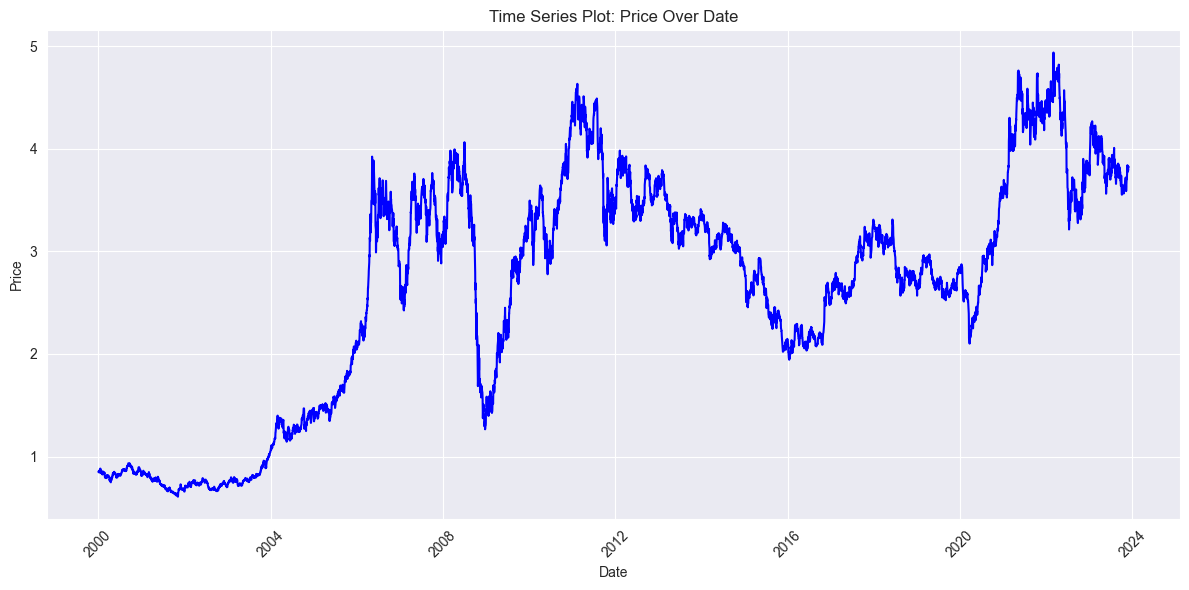

In [742]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(copper_history['Date'], copper_history['Price'], linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time Series Plot: Price Over Date')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

In [743]:
# Eliminating Outliers
lower_bound = 0.1
for index, row in copper_history.iterrows():
    if row['Price'] < lower_bound:
        # Calculate the mean of the previous 7 days' prices
        start_date = row['Date'] - pd.DateOffset(days=8)
        end_date = row['Date'] - pd.DateOffset(days=1)
        previous_7_days_mean = copper_history[(copper_history['Date'] >= start_date) & (copper_history['Date'] <= end_date)]['Price'].mean()

        # Replace 'updated_price' with the calculated mean
        copper_history.at[index, 'Price'] = previous_7_days_mean
copper_history.sort_values(by="Date")

,Date,Price,Day,Month,Year
0,2000-01-04,0.8480,4,1,2000
1,2000-01-05,0.8565,5,1,2000
2,2000-01-06,0.8530,6,1,2000
3,2000-01-07,0.8540,7,1,2000
4,2000-01-10,0.8465,10,1,2000
...,...,...,...,...,...
6079,2023-11-24,3.8205,24,11,2023
6080,2023-11-27,3.7890,27,11,2023
6081,2023-11-28,3.8285,28,11,2023
6082,2023-11-29,3.8255,29,11,2023


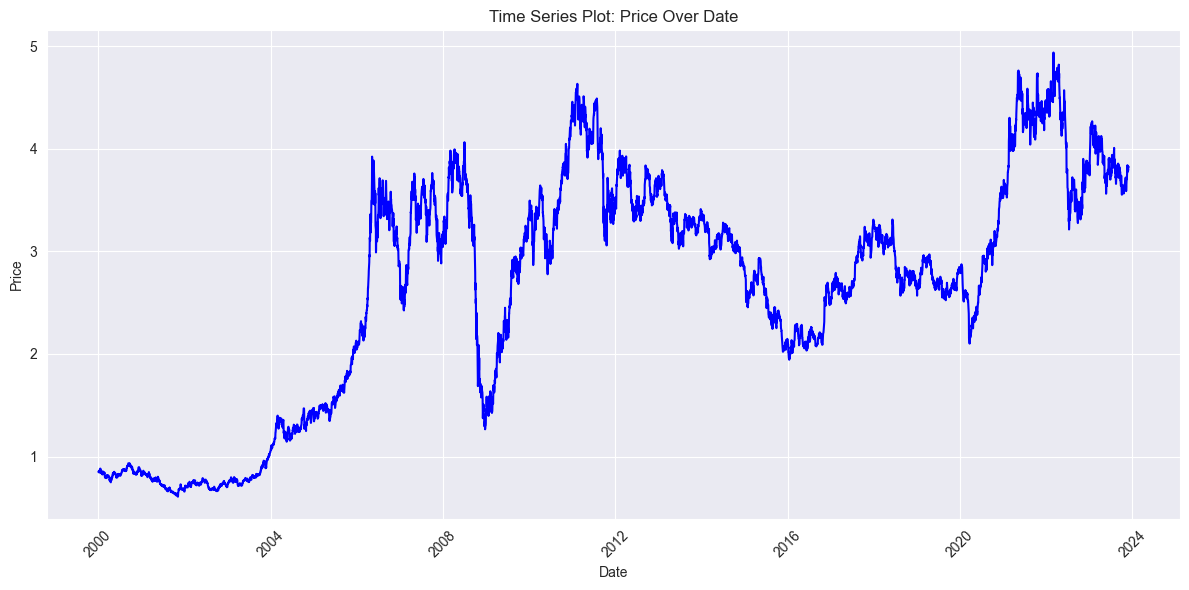

In [744]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(copper_history['Date'], copper_history['Price'], linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time Series Plot: Price Over Date')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

In [745]:
# Extract day, month, and year into separate columns
copper_history['Day'] = copper_history['Date'].dt.day
copper_history['Month'] = copper_history['Date'].dt.month
copper_history['Year'] = copper_history['Date'].dt.year

In [746]:
copper_history

,Date,Price,Day,Month,Year
0,2000-01-04,0.8480,4,1,2000
1,2000-01-05,0.8565,5,1,2000
2,2000-01-06,0.8530,6,1,2000
3,2000-01-07,0.8540,7,1,2000
4,2000-01-10,0.8465,10,1,2000
...,...,...,...,...,...
6079,2023-11-24,3.8205,24,11,2023
6080,2023-11-27,3.7890,27,11,2023
6081,2023-11-28,3.8285,28,11,2023
6082,2023-11-29,3.8255,29,11,2023


In [747]:
copper_history.dtypes

Date     datetime64[ns]
Price           float64
Day               int64
Month             int64
Year              int64
dtype: object

In [748]:
copper_history.isnull().sum()

Date     0
Price    0
Day      0
Month    0
Year     0
dtype: int64

### Real GDP

In [749]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=REAL_GDP&interval=annual&apikey=demo'
r = requests.get(url)
data = r.json()

# Extract the time series data
time_series = data['data']

# Create a DataFrame from the time series data
df_GDP = pd.DataFrame(time_series)
df_GDP

,date,value
0,2022-01-01,21822.037
1,2021-01-01,21407.692
2,2020-01-01,20234.074
3,2019-01-01,20692.087
4,2018-01-01,20193.896
...,...,...
89,1933-01-01,877.431
90,1932-01-01,888.414
91,1931-01-01,1019.977
92,1930-01-01,1089.785


In [750]:
df_GDP['date'] = pd.to_datetime(df_GDP['date'])

In [751]:
df_GDP.sort_values(by='date')

,date,value
93,1929-01-01,1191.124
92,1930-01-01,1089.785
91,1931-01-01,1019.977
90,1932-01-01,888.414
89,1933-01-01,877.431
...,...,...
4,2018-01-01,20193.896
3,2019-01-01,20692.087
2,2020-01-01,20234.074
1,2021-01-01,21407.692


In [752]:
df_GDP['Year'] = df_GDP['date'].dt.year
df_GDP

,date,value,Year
0,2022-01-01,21822.037,2022
1,2021-01-01,21407.692,2021
2,2020-01-01,20234.074,2020
3,2019-01-01,20692.087,2019
4,2018-01-01,20193.896,2018
...,...,...,...
89,1933-01-01,877.431,1933
90,1932-01-01,888.414,1932
91,1931-01-01,1019.977,1931
92,1930-01-01,1089.785,1930


In [753]:
empty = df_GDP[df_GDP['value'] == ''].index
df_GDP.drop(empty , inplace=True)

In [754]:
df_GDP['value'] = df_GDP['value'].astype(float)

In [755]:
df_GDP.rename(columns = {'value':'Real_GDP','date':'Date'}, inplace = True)
df_GDP

,Date,Real_GDP,Year
0,2022-01-01,21822.037,2022
1,2021-01-01,21407.692,2021
2,2020-01-01,20234.074,2020
3,2019-01-01,20692.087,2019
4,2018-01-01,20193.896,2018
...,...,...,...
89,1933-01-01,877.431,1933
90,1932-01-01,888.414,1932
91,1931-01-01,1019.977,1931
92,1930-01-01,1089.785,1930


In [756]:
df_GDP = df_GDP[df_GDP['Date'] >= '2000-01-01']
df_GDP

,Date,Real_GDP,Year
0,2022-01-01,21822.037,2022
1,2021-01-01,21407.692,2021
2,2020-01-01,20234.074,2020
3,2019-01-01,20692.087,2019
4,2018-01-01,20193.896,2018
5,2017-01-01,19612.102,2017
6,2016-01-01,19141.672,2016
7,2015-01-01,18799.622,2015
8,2014-01-01,18261.714,2014
9,2013-01-01,17812.167,2013


In [757]:
df_GDP = df_GDP.sort_values(by='Date')
df_GDP

,Date,Real_GDP,Year
22,2000-01-01,14096.033,2000
21,2001-01-01,14230.726,2001
20,2002-01-01,14472.712,2002
19,2003-01-01,14877.312,2003
18,2004-01-01,15449.757,2004
17,2005-01-01,15987.957,2005
16,2006-01-01,16433.148,2006
15,2007-01-01,16762.445,2007
14,2008-01-01,16781.485,2008
13,2009-01-01,16349.110,2009


### Consumer Price Index (CPI)

In [758]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=CPI&interval=monthly&apikey=demo'
r = requests.get(url)
data_CPI = r.json()

# Extract the time series data
time_series_CPI = data_CPI['data']

# Create a DataFrame from the time series data
df_CPI = pd.DataFrame(time_series_CPI)

In [759]:
df_CPI['date'] = pd.to_datetime(df_CPI['date'])
df_CPI

,date,value
0,2023-10-01,307.671
1,2023-09-01,307.789
2,2023-08-01,307.026
3,2023-07-01,305.691
4,2023-06-01,305.109
...,...,...
1325,1913-05-01,9.700
1326,1913-04-01,9.800
1327,1913-03-01,9.800
1328,1913-02-01,9.800


In [760]:
empty_CPI = df_CPI[df_CPI['value'] == ''].index
df_CPI.drop(empty_CPI , inplace=True)

In [761]:
df_CPI['value'] = df_CPI['value'].astype(float)
df_CPI.dtypes

date     datetime64[ns]
value           float64
dtype: object

In [762]:
df_CPI.rename(columns = {'value':'CPI', 'date':'Date'}, inplace = True)
df_CPI

,Date,CPI
0,2023-10-01,307.671
1,2023-09-01,307.789
2,2023-08-01,307.026
3,2023-07-01,305.691
4,2023-06-01,305.109
...,...,...
1325,1913-05-01,9.700
1326,1913-04-01,9.800
1327,1913-03-01,9.800
1328,1913-02-01,9.800


In [763]:
df_CPI = df_CPI[df_CPI['Date'] >= '2000-01-01']
df_CPI

,Date,CPI
0,2023-10-01,307.671
1,2023-09-01,307.789
2,2023-08-01,307.026
3,2023-07-01,305.691
4,2023-06-01,305.109
...,...,...
281,2000-05-01,171.500
282,2000-04-01,171.300
283,2000-03-01,171.200
284,2000-02-01,169.800


In [764]:
df_CPI = df_CPI.sort_values(by='Date')
df_CPI

,Date,CPI
285,2000-01-01,168.800
284,2000-02-01,169.800
283,2000-03-01,171.200
282,2000-04-01,171.300
281,2000-05-01,171.500
...,...,...
4,2023-06-01,305.109
3,2023-07-01,305.691
2,2023-08-01,307.026
1,2023-09-01,307.789


### Inflation Rates

In [765]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=INFLATION&apikey=demo'
r = requests.get(url)
inflation = r.json()

# Extract the time series data
time_series = inflation['data']

# Create a DataFrame from the time series data
df_inf = pd.DataFrame(time_series)

In [766]:
df_inf.head(10)

,date,value
0,2022-01-01,8.00279982052117
1,2021-01-01,4.69785886363739
2,2020-01-01,1.23358439630637
3,2019-01-01,1.81221007526015
4,2018-01-01,2.44258329692818
5,2017-01-01,2.13011000365963
6,2016-01-01,1.26158320570537
7,2015-01-01,0.118627135552435
8,2014-01-01,1.62222297740821
9,2013-01-01,1.46483265562714


In [767]:
df_inf['date'] = pd.to_datetime(df_inf['date'])
df_inf

,date,value
0,2022-01-01,8.00279982052117
1,2021-01-01,4.69785886363739
2,2020-01-01,1.23358439630637
3,2019-01-01,1.81221007526015
4,2018-01-01,2.44258329692818
...,...,...
58,1964-01-01,1.27891156462583
59,1963-01-01,1.2396694214876
60,1962-01-01,1.19877334820185
61,1961-01-01,1.07072414764723


In [768]:
df_inf.rename(columns = {'value':'inflation_rate','date':'Date'}, inplace = True)
df_inf

,Date,inflation_rate
0,2022-01-01,8.00279982052117
1,2021-01-01,4.69785886363739
2,2020-01-01,1.23358439630637
3,2019-01-01,1.81221007526015
4,2018-01-01,2.44258329692818
...,...,...
58,1964-01-01,1.27891156462583
59,1963-01-01,1.2396694214876
60,1962-01-01,1.19877334820185
61,1961-01-01,1.07072414764723


In [769]:
df_inf['Year'] = df_inf['Date'].dt.year
df_inf

,Date,inflation_rate,Year
0,2022-01-01,8.00279982052117,2022
1,2021-01-01,4.69785886363739,2021
2,2020-01-01,1.23358439630637,2020
3,2019-01-01,1.81221007526015,2019
4,2018-01-01,2.44258329692818,2018
...,...,...,...
58,1964-01-01,1.27891156462583,1964
59,1963-01-01,1.2396694214876,1963
60,1962-01-01,1.19877334820185,1962
61,1961-01-01,1.07072414764723,1961


In [770]:
df_inf = df_inf[df_inf['Date'] >= '2000-01-01']
df_inf = df_inf.sort_values(by='Date')
df_inf

,Date,inflation_rate,Year
22,2000-01-01,3.37685727149935,2000
21,2001-01-01,2.82617111885402,2001
20,2002-01-01,1.58603162650603,2002
19,2003-01-01,2.27009497336113,2003
18,2004-01-01,2.67723669309173,2004
17,2005-01-01,3.39274684549547,2005
16,2006-01-01,3.22594410070407,2006
15,2007-01-01,2.85267248150136,2007
14,2008-01-01,3.83910029665101,2008
13,2009-01-01,-0.35554626629975,2009


### Global Price Index of All Commodities

In [771]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=ALL_COMMODITIES&interval=monthly&apikey=demo'
r = requests.get(url)
com = r.json()

# Extract the time series data
time_series = com['data']

# Create a DataFrame from the time series data
df_com = pd.DataFrame(time_series)
df_com

,date,value
0,2023-10-01,167.77064363426
1,2023-09-01,168.657488561668
2,2023-08-01,161.30619330389
3,2023-07-01,157.908976461302
4,2023-06-01,154.069169324197
...,...,...
377,1992-05-01,.
378,1992-04-01,.
379,1992-03-01,.
380,1992-02-01,.


In [772]:
df_com['date'] = pd.to_datetime(df_com['date'])
df_com

,date,value
0,2023-10-01,167.77064363426
1,2023-09-01,168.657488561668
2,2023-08-01,161.30619330389
3,2023-07-01,157.908976461302
4,2023-06-01,154.069169324197
...,...,...
377,1992-05-01,.
378,1992-04-01,.
379,1992-03-01,.
380,1992-02-01,.


In [773]:
df_com.rename(columns = {'value':'PALLFNFINDEXM','date':'Date'}, inplace = True)

In [774]:
df_com = df_com[df_com['Date'] >= '2000-01-01']
df_com

,Date,PALLFNFINDEXM
0,2023-10-01,167.77064363426
1,2023-09-01,168.657488561668
2,2023-08-01,161.30619330389
3,2023-07-01,157.908976461302
4,2023-06-01,154.069169324197
...,...,...
281,2000-05-01,.
282,2000-04-01,.
283,2000-03-01,.
284,2000-02-01,.


In [775]:
missing = df_com[df_com['PALLFNFINDEXM'] == '.']
missing.sort_values(by='Date', inplace=True)
missing

,Date,PALLFNFINDEXM
285,2000-01-01,.
284,2000-02-01,.
283,2000-03-01,.
282,2000-04-01,.
281,2000-05-01,.
280,2000-06-01,.
279,2000-07-01,.
278,2000-08-01,.
277,2000-09-01,.
276,2000-10-01,.


> Values from 2000-01-01 to 2002-12-01 are missing

In [776]:
# Replace "." with NaN
missing['PALLFNFINDEXM'] = missing['PALLFNFINDEXM'].replace('.', np.nan)
missing

,Date,PALLFNFINDEXM
285,2000-01-01,NaN
284,2000-02-01,NaN
283,2000-03-01,NaN
282,2000-04-01,NaN
281,2000-05-01,NaN
280,2000-06-01,NaN
279,2000-07-01,NaN
278,2000-08-01,NaN
277,2000-09-01,NaN
276,2000-10-01,NaN


In [777]:
# Filling values from nasdaq.com
replacement_numbers = [55.66, 58.06, 58.51, 56.61, 59.33, 61.24, 59.90, 60.84, 63.62, 62.95, 63.88, 64.21,
                       63.96, 61.03, 59.15, 59.37, 60.11, 58.42, 55.81, 56.04, 54.02, 50.43, 48.19, 47.89,
                       48.62, 49.52, 53.93, 55.67, 55.82, 54.77, 56.44, 56.67, 58.90, 60.07, 58.02, 61.15]

# Replace NaN with numbers from the list
nan_indices = missing['PALLFNFINDEXM'].isna()
missing.loc[nan_indices, 'PALLFNFINDEXM'] = replacement_numbers
missing.sort_values(by="Date", ascending=True)
missing

,Date,PALLFNFINDEXM
285,2000-01-01,55.66
284,2000-02-01,58.06
283,2000-03-01,58.51
282,2000-04-01,56.61
281,2000-05-01,59.33
280,2000-06-01,61.24
279,2000-07-01,59.90
278,2000-08-01,60.84
277,2000-09-01,63.62
276,2000-10-01,62.95


In [778]:
df_com = df_com[df_com['Date'] > '2002-12-01']
df_com = df_com.sort_values(by='Date')
df_com

,Date,PALLFNFINDEXM
249,2003-01-01,65.1533780787117
248,2003-02-01,70.2295140727457
247,2003-03-01,65.782767587809
246,2003-04-01,61.8871994794742
245,2003-05-01,63.0659772161954
...,...,...
4,2023-06-01,154.069169324197
3,2023-07-01,157.908976461302
2,2023-08-01,161.30619330389
1,2023-09-01,168.657488561668


In [779]:
df_com['Date'] = pd.to_datetime(df_com['Date'])
missing['Date'] = pd.to_datetime(missing['Date'])

In [780]:
# Concatenating both datasets
commodity = pd.concat([missing, df_com], ignore_index=True)
commodity = commodity.sort_values(by='Date')
commodity

,Date,PALLFNFINDEXM
0,2000-01-01,55.66
1,2000-02-01,58.06
2,2000-03-01,58.51
3,2000-04-01,56.61
4,2000-05-01,59.33
...,...,...
281,2023-06-01,154.069169324197
282,2023-07-01,157.908976461302
283,2023-08-01,161.30619330389
284,2023-09-01,168.657488561668


In [781]:
commodity['PALLFNFINDEXM'] = commodity['PALLFNFINDEXM'].astype(float)
commodity.dtypes

Date             datetime64[ns]
PALLFNFINDEXM           float64
dtype: object

## **Merging Datasets**

In [782]:
copper_history = copper_history[copper_history['Date'] >= '2000-01-01']
copper_history

,Date,Price,Day,Month,Year
0,2000-01-04,0.8480,4,1,2000
1,2000-01-05,0.8565,5,1,2000
2,2000-01-06,0.8530,6,1,2000
3,2000-01-07,0.8540,7,1,2000
4,2000-01-10,0.8465,10,1,2000
...,...,...,...,...,...
6079,2023-11-24,3.8205,24,11,2023
6080,2023-11-27,3.7890,27,11,2023
6081,2023-11-28,3.8285,28,11,2023
6082,2023-11-29,3.8255,29,11,2023


In [783]:
# Merge data frames based on a common key
merged_df_1 = pd.merge(copper_history, df_GDP, left_on='Year', right_on='Year', how='outer')
merged_df_1

,Date_x,Price,Day,Month,Year,Date_y,Real_GDP
0,2000-01-04,0.8480,4,1,2000,2000-01-01,14096.033
1,2000-01-05,0.8565,5,1,2000,2000-01-01,14096.033
2,2000-01-06,0.8530,6,1,2000,2000-01-01,14096.033
3,2000-01-07,0.8540,7,1,2000,2000-01-01,14096.033
4,2000-01-10,0.8465,10,1,2000,2000-01-01,14096.033
...,...,...,...,...,...,...,...
6079,2023-11-24,3.8205,24,11,2023,NaT,NaN
6080,2023-11-27,3.7890,27,11,2023,NaT,NaN
6081,2023-11-28,3.8285,28,11,2023,NaT,NaN
6082,2023-11-29,3.8255,29,11,2023,NaT,NaN


In [784]:
merged_df_1 = merged_df_1.drop(columns=['Date_y'])

merged_df_1.rename(columns = {'Date_x':'Date'}, inplace = True)

merged_df_1

,Date,Price,Day,Month,Year,Real_GDP
0,2000-01-04,0.8480,4,1,2000,14096.033
1,2000-01-05,0.8565,5,1,2000,14096.033
2,2000-01-06,0.8530,6,1,2000,14096.033
3,2000-01-07,0.8540,7,1,2000,14096.033
4,2000-01-10,0.8465,10,1,2000,14096.033
...,...,...,...,...,...,...
6079,2023-11-24,3.8205,24,11,2023,NaN
6080,2023-11-27,3.7890,27,11,2023,NaN
6081,2023-11-28,3.8285,28,11,2023,NaN
6082,2023-11-29,3.8255,29,11,2023,NaN


In [785]:
merged_df_1 = merged_df_1.drop(['Day'], axis=1)
merged_df_1

,Date,Price,Month,Year,Real_GDP
0,2000-01-04,0.8480,1,2000,14096.033
1,2000-01-05,0.8565,1,2000,14096.033
2,2000-01-06,0.8530,1,2000,14096.033
3,2000-01-07,0.8540,1,2000,14096.033
4,2000-01-10,0.8465,1,2000,14096.033
...,...,...,...,...,...
6079,2023-11-24,3.8205,11,2023,NaN
6080,2023-11-27,3.7890,11,2023,NaN
6081,2023-11-28,3.8285,11,2023,NaN
6082,2023-11-29,3.8255,11,2023,NaN


In [786]:
# Forward fill the missing Real_GDP values by grouping them by Year
merged_df_1['Real_GDP'] = merged_df_1.groupby('Year')['Real_GDP'].fillna(method='ffill')
merged_df_1

,Date,Price,Month,Year,Real_GDP
0,2000-01-04,0.8480,1,2000,14096.033
1,2000-01-05,0.8565,1,2000,14096.033
2,2000-01-06,0.8530,1,2000,14096.033
3,2000-01-07,0.8540,1,2000,14096.033
4,2000-01-10,0.8465,1,2000,14096.033
...,...,...,...,...,...
6079,2023-11-24,3.8205,11,2023,NaN
6080,2023-11-27,3.7890,11,2023,NaN
6081,2023-11-28,3.8285,11,2023,NaN
6082,2023-11-29,3.8255,11,2023,NaN


> Real_GDP value change every year

In [787]:
# Set a constant value for missing 'Real_GDP' in the year 2023
constant_value_2023 = 19374

# Fill the missing 'Real_GDP' values with the constant value for 2023
merged_df_1['Real_GDP'] = merged_df_1['Real_GDP'].fillna(
    merged_df_1['Year'].apply(lambda x: constant_value_2023 if x == 2023 else np.nan))

In [788]:
merged_df_1

,Date,Price,Month,Year,Real_GDP
0,2000-01-04,0.8480,1,2000,14096.033
1,2000-01-05,0.8565,1,2000,14096.033
2,2000-01-06,0.8530,1,2000,14096.033
3,2000-01-07,0.8540,1,2000,14096.033
4,2000-01-10,0.8465,1,2000,14096.033
...,...,...,...,...,...
6079,2023-11-24,3.8205,11,2023,19374.000
6080,2023-11-27,3.7890,11,2023,19374.000
6081,2023-11-28,3.8285,11,2023,19374.000
6082,2023-11-29,3.8255,11,2023,19374.000


In [789]:
# Interpolate the missing values using linear interpolation
merged_df_1.interpolate(method='ffill', inplace=True)
print(merged_df_1)

           Date   Price  Month  Year   Real_GDP
0    2000-01-04  0.8480      1  2000  14096.033
1    2000-01-05  0.8565      1  2000  14096.033
2    2000-01-06  0.8530      1  2000  14096.033
3    2000-01-07  0.8540      1  2000  14096.033
4    2000-01-10  0.8465      1  2000  14096.033
...         ...     ...    ...   ...        ...
6079 2023-11-24  3.8205     11  2023  19374.000
6080 2023-11-27  3.7890     11  2023  19374.000
6081 2023-11-28  3.8285     11  2023  19374.000
6082 2023-11-29  3.8255     11  2023  19374.000
6083 2023-11-30  3.8213     11  2023  19374.000

[6084 rows x 5 columns]


In [790]:

# Second Merge
merged_df_2 = pd.merge(merged_df_1, df_CPI, on='Date', how='left')
merged_df_2.loc[(merged_df_2['Year'] == 2000) & (merged_df_2['Month'] == 1), 'CPI'] = 168.8
merged_df_2

,Date,Price,Month,Year,Real_GDP,CPI
0,2000-01-04,0.8480,1,2000,14096.033,168.8
1,2000-01-05,0.8565,1,2000,14096.033,168.8
2,2000-01-06,0.8530,1,2000,14096.033,168.8
3,2000-01-07,0.8540,1,2000,14096.033,168.8
4,2000-01-10,0.8465,1,2000,14096.033,168.8
...,...,...,...,...,...,...
6079,2023-11-24,3.8205,11,2023,19374.000,NaN
6080,2023-11-27,3.7890,11,2023,19374.000,NaN
6081,2023-11-28,3.8285,11,2023,19374.000,NaN
6082,2023-11-29,3.8255,11,2023,19374.000,NaN


In [791]:
import pandas as pd

# Assuming merged_df_2 is your DataFrame

# Filter the DataFrame for data before the year 2023
filtered_df = merged_df_2[merged_df_2['Date'].dt.year < 2023]

# Group by year and month, and transform 'CPI' to fill missing values with the first value of the group
filtered_df['CPI'] = filtered_df.groupby([filtered_df['Date'].dt.year, filtered_df['Date'].dt.month])['CPI'].transform('first')

# Forward fill missing values within the filtered DataFrame
filtered_df['CPI'] = filtered_df['CPI'].ffill()

# Update the original DataFrame with the modified values
merged_df_2.update(filtered_df)
merged_df_2

,Date,Price,Month,Year,Real_GDP,CPI
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8
...,...,...,...,...,...,...
6079,2023-11-24,3.8205,11.0,2023.0,19374.000,NaN
6080,2023-11-27,3.7890,11.0,2023.0,19374.000,NaN
6081,2023-11-28,3.8285,11.0,2023.0,19374.000,NaN
6082,2023-11-29,3.8255,11.0,2023.0,19374.000,NaN


In [792]:
merged_df_2.isnull().sum()

Date          0
Price         0
Month         0
Year          0
Real_GDP      0
CPI         237
dtype: int64

In [793]:
# Set a constant value for missing 'CPI' in the year 2023
constant_value_CPI_2023 = 307.0
# Fill the missing 'CPI' values with the constant value for 2023
merged_df_2['CPI'] = merged_df_2['CPI'].fillna(
    merged_df_2['Year'].apply(lambda x: constant_value_CPI_2023 if x == 2023 else np.nan))

merged_df_2

,Date,Price,Month,Year,Real_GDP,CPI
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8
...,...,...,...,...,...,...
6079,2023-11-24,3.8205,11.0,2023.0,19374.000,307.0
6080,2023-11-27,3.7890,11.0,2023.0,19374.000,307.0
6081,2023-11-28,3.8285,11.0,2023.0,19374.000,307.0
6082,2023-11-29,3.8255,11.0,2023.0,19374.000,307.0


In [794]:
merged_df_2.head(20)

,Date,Price,Month,Year,Real_GDP,CPI
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8
5,2000-01-11,0.8435,1.0,2000.0,14096.033,168.8
6,2000-01-12,0.8660,1.0,2000.0,14096.033,168.8
7,2000-01-13,0.8565,1.0,2000.0,14096.033,168.8
8,2000-01-14,0.8625,1.0,2000.0,14096.033,168.8
9,2000-01-18,0.8660,1.0,2000.0,14096.033,168.8


In [795]:
# Set a constant value for missing 'CPI' in the year 2023
#constant_value_CPI_jan_2000 = 165.600
# Fill the missing 'CPI' values with the constant value for 2023
#merged_df_2['CPI'] = merged_df_2['CPI'].fillna(
    #merged_df_2['Year'].apply(lambda x: constant_value_CPI_jan_2000 if x == 2000 else np.nan))

#merged_df_2

In [796]:
# Third Merge data frames based on a common key
merged_df_3 = pd.merge(merged_df_2, df_inf, left_on='Year', right_on='Year', how='outer')
merged_df_3

,Date_x,Price,Month,Year,Real_GDP,CPI,Date_y,inflation_rate
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8,2000-01-01,3.37685727149935
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8,2000-01-01,3.37685727149935
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8,2000-01-01,3.37685727149935
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8,2000-01-01,3.37685727149935
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8,2000-01-01,3.37685727149935
...,...,...,...,...,...,...,...,...
6079,2023-11-24,3.8205,11.0,2023.0,19374.000,307.0,NaT,NaN
6080,2023-11-27,3.7890,11.0,2023.0,19374.000,307.0,NaT,NaN
6081,2023-11-28,3.8285,11.0,2023.0,19374.000,307.0,NaT,NaN
6082,2023-11-29,3.8255,11.0,2023.0,19374.000,307.0,NaT,NaN


In [797]:
merged_df_3 = merged_df_3.drop(['Date_y'], axis=1)

merged_df_3.rename(columns = {'Date_x': 'Date'}, inplace = True)

merged_df_3

,Date,Price,Month,Year,Real_GDP,CPI,inflation_rate
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8,3.37685727149935
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8,3.37685727149935
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8,3.37685727149935
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8,3.37685727149935
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8,3.37685727149935
...,...,...,...,...,...,...,...
6079,2023-11-24,3.8205,11.0,2023.0,19374.000,307.0,NaN
6080,2023-11-27,3.7890,11.0,2023.0,19374.000,307.0,NaN
6081,2023-11-28,3.8285,11.0,2023.0,19374.000,307.0,NaN
6082,2023-11-29,3.8255,11.0,2023.0,19374.000,307.0,NaN


In [798]:
# Forward fill the missing Real_GDP values by grouping them by Year
merged_df_3['inflation_rate'] = merged_df_3.groupby('Year')['inflation_rate'].fillna(method='ffill')
merged_df_3

,Date,Price,Month,Year,Real_GDP,CPI,inflation_rate
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8,3.37685727149935
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8,3.37685727149935
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8,3.37685727149935
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8,3.37685727149935
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8,3.37685727149935
...,...,...,...,...,...,...,...
6079,2023-11-24,3.8205,11.0,2023.0,19374.000,307.0,NaN
6080,2023-11-27,3.7890,11.0,2023.0,19374.000,307.0,NaN
6081,2023-11-28,3.8285,11.0,2023.0,19374.000,307.0,NaN
6082,2023-11-29,3.8255,11.0,2023.0,19374.000,307.0,NaN


In [799]:
# Set a constant value for missing 'inflation_rate' in the year 2023
inflation_rate_2023 = 6.6

# Fill the missing 'inflation_rate' values with the constant value for 2023
merged_df_3['inflation_rate'] = merged_df_3['inflation_rate'].fillna(
    merged_df_3['Year'].apply(lambda x: inflation_rate_2023 if x == 2023 else np.nan))

merged_df_3

,Date,Price,Month,Year,Real_GDP,CPI,inflation_rate
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8,3.37685727149935
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8,3.37685727149935
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8,3.37685727149935
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8,3.37685727149935
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8,3.37685727149935
...,...,...,...,...,...,...,...
6079,2023-11-24,3.8205,11.0,2023.0,19374.000,307.0,6.6
6080,2023-11-27,3.7890,11.0,2023.0,19374.000,307.0,6.6
6081,2023-11-28,3.8285,11.0,2023.0,19374.000,307.0,6.6
6082,2023-11-29,3.8255,11.0,2023.0,19374.000,307.0,6.6


In [800]:
# Final Merge
final_merged_dataset = pd.merge(merged_df_3, commodity, on='Date', how='left')
final_merged_dataset

,Date,Price,Month,Year,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
...,...,...,...,...,...,...,...,...
6079,2023-11-24,3.8205,11.0,2023.0,19374.000,307.0,6.6,NaN
6080,2023-11-27,3.7890,11.0,2023.0,19374.000,307.0,6.6,NaN
6081,2023-11-28,3.8285,11.0,2023.0,19374.000,307.0,6.6,NaN
6082,2023-11-29,3.8255,11.0,2023.0,19374.000,307.0,6.6,NaN


In [801]:
final_merged_dataset['PALLFNFINDEXM'].isnull().sum()

5896

In [802]:
# Group by year and month, and transform Indicator1 to fill missing values with the first value of the group
final_merged_dataset['PALLFNFINDEXM'] = final_merged_dataset.groupby([final_merged_dataset['Date'].dt.year,
                                                 final_merged_dataset['Date'].dt.month])['PALLFNFINDEXM'].transform('first')

final_merged_dataset['PALLFNFINDEXM'] = final_merged_dataset['PALLFNFINDEXM'].ffill()
final_merged_dataset

,Date,Price,Month,Year,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
...,...,...,...,...,...,...,...,...
6079,2023-11-24,3.8205,11.0,2023.0,19374.000,307.0,6.6,168.657489
6080,2023-11-27,3.7890,11.0,2023.0,19374.000,307.0,6.6,168.657489
6081,2023-11-28,3.8285,11.0,2023.0,19374.000,307.0,6.6,168.657489
6082,2023-11-29,3.8255,11.0,2023.0,19374.000,307.0,6.6,168.657489


In [803]:
final_merged_dataset.head(25)

,Date,Price,Month,Year,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
5,2000-01-11,0.8435,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
6,2000-01-12,0.8660,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
7,2000-01-13,0.8565,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
8,2000-01-14,0.8625,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN
9,2000-01-18,0.8660,1.0,2000.0,14096.033,168.8,3.37685727149935,NaN


In [804]:
# Set a constant value for missing 'PALLFNFINDEXM' in the year 2000
PALLFNFINDEXM_2000 = 59.47

# Fill the missing 'PALLFNFINDEXM' values with the constant value for 2000
final_merged_dataset['PALLFNFINDEXM'] = final_merged_dataset['PALLFNFINDEXM'].fillna(
    final_merged_dataset['Year'].apply(lambda x: PALLFNFINDEXM_2000 if x == 2000 else np.nan))

final_merged_dataset

,Date,Price,Month,Year,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8,3.37685727149935,59.470000
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8,3.37685727149935,59.470000
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8,3.37685727149935,59.470000
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8,3.37685727149935,59.470000
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8,3.37685727149935,59.470000
...,...,...,...,...,...,...,...,...
6079,2023-11-24,3.8205,11.0,2023.0,19374.000,307.0,6.6,168.657489
6080,2023-11-27,3.7890,11.0,2023.0,19374.000,307.0,6.6,168.657489
6081,2023-11-28,3.8285,11.0,2023.0,19374.000,307.0,6.6,168.657489
6082,2023-11-29,3.8255,11.0,2023.0,19374.000,307.0,6.6,168.657489


In [805]:
final_merged_dataset['PALLFNFINDEXM'].isnull().sum()

0

In [807]:
final_merged_dataset = pd.merge(final_merged_dataset, dexchus, on='Date', how='inner')

In [809]:
final_merged_dataset

,Date,Price,Month,Year,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM,DEXCHUS
0,2000-01-04,0.8480,1.0,2000.0,14096.033,168.8,3.37685727149935,59.470000,0.120774
1,2000-01-05,0.8565,1.0,2000.0,14096.033,168.8,3.37685727149935,59.470000,0.120776
2,2000-01-06,0.8530,1.0,2000.0,14096.033,168.8,3.37685727149935,59.470000,0.120777
3,2000-01-07,0.8540,1.0,2000.0,14096.033,168.8,3.37685727149935,59.470000,0.120782
4,2000-01-10,0.8465,1.0,2000.0,14096.033,168.8,3.37685727149935,59.470000,0.120782
...,...,...,...,...,...,...,...,...,...
6047,2023-11-20,3.8335,11.0,2023.0,19374.000,307.0,6.6,168.657489,0.139509
6048,2023-11-21,3.8395,11.0,2023.0,19374.000,307.0,6.6,168.657489,0.140150
6049,2023-11-22,3.7970,11.0,2023.0,19374.000,307.0,6.6,168.657489,0.139762
6050,2023-11-23,3.7743,11.0,2023.0,19374.000,307.0,6.6,168.657489,0.139823


In [810]:
final_merged_dataset.isna().sum()

Date              0
Price             0
Month             0
Year              0
Real_GDP          0
CPI               0
inflation_rate    0
PALLFNFINDEXM     0
DEXCHUS           0
dtype: int64

In [811]:
final_merged_dataset.to_csv('../DataFrames/final_merged_copper_dataset.csv')